# 8. Calibration of double ended measurement with WLS and confidence intervals

## Calibration procedure
A double ended calibration is performed with weighted least squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are not considered equal here. The weights kwadratically decrease with the signal strength of the measured Stokes and anti-Stokes signals.

The confidence intervals can be calculated as the weights are correctly defined.

The confidence intervals consist of two sources of uncertainty.

1. Measurement noise in the measured Stokes and anti-Stokes signals. Expressed in a single variance value.
2. Inherent to least squares procedures / overdetermined systems, the parameters are estimated with limited certainty and all parameters are correlated. Which is expressen in the covariance matrix.

Both sources of uncertainty are propagated to an uncertainty in the estimated temperature via Monte Carlo.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


In [3]:
st_label = 'ST'
ast_label = 'AST'
rst_label = 'REV-ST'
rast_label = 'REV-AST'

First calculate the variance in the measured Stokes and anti-Stokes signals, in the forward and backward direction.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals.

In [4]:
st_var, resid = ds.variance_stokes(st_label=st_label)
ast_var, _ = ds.variance_stokes(st_label=ast_label)
rst_var, _ = ds.variance_stokes(st_label=rst_label)
rast_var, _ = ds.variance_stokes(st_label=rast_label)

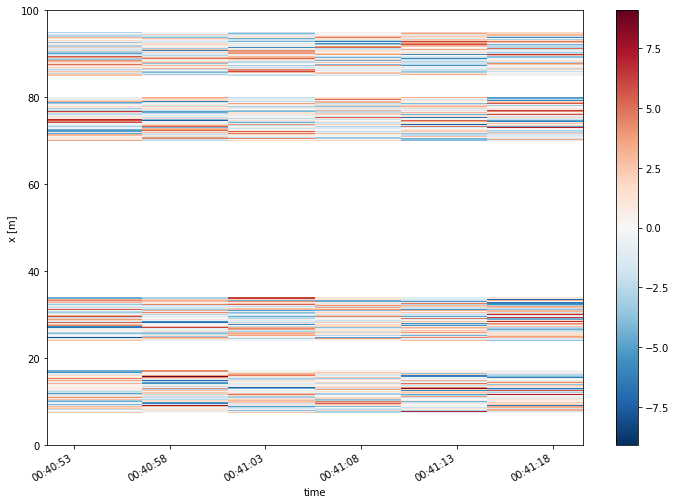

In [5]:
resid.plot(figsize=(12, 8));

We calibrate the measurement with a single method call. The labels refer to the keys in the DataStore object containing the Stokes, anti-Stokes, reverse Stokes and reverse anti-Stokes. The variance in those measurements were calculated in the previous step. We use a sparse solver because it saves us memory.

In [6]:
ds.calibration_double_ended(
    st_label=st_label,
    ast_label=ast_label,
    rst_label=rst_label,
    rast_label=rast_label,
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='TMPW',
    method='wls',
    solver='sparse')

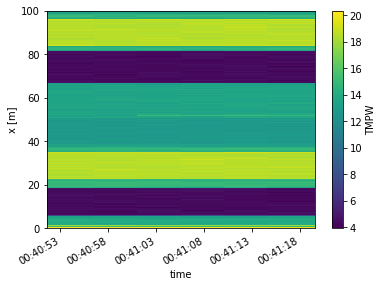

In [7]:
ds.TMPW.plot()

## Confidence intervals

With another method call we estimate the confidence intervals. If the method is `wls` and confidence intervals are passed to `conf_ints`, confidence intervals calculated. As weigths are correctly passed to the least squares procedure, the covariance matrix can be used as an estimator for the uncertainty in the parameters. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix as part of the Monte Carlo routine, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated.

The confidence intervals differ per time step. If you would like to calculate confidence intervals of all time steps together you have the option `ci_avg_time_flag=True`. 'We can say with 95% confidence that the temperature remained between this line and this line during the entire measurement period'. This is ideal if you'd like to calculate the background temperature with a confidence interval.

In [8]:
ds.conf_int_double_ended(
    p_val='p_val',
    p_cov='p_cov',
    st_label=st_label,
    ast_label=ast_label,
    rst_label=rst_label,
    rast_label=rast_label,
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpf='TMPF',
    store_tmpb='TMPB',
    store_tmpw='TMPW',
    store_tempvar='_var',
    conf_ints=[2.5, 50., 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_time_flag=False)

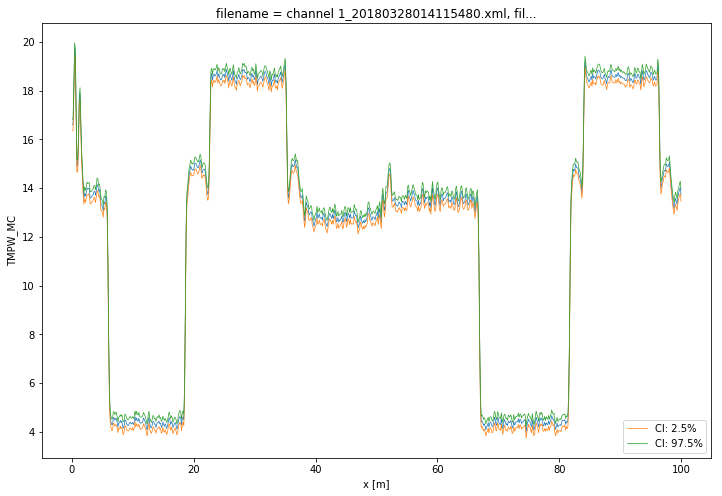

In [9]:
ds1 = ds.isel(time=-1)  # take only the first timestep
ds1.TMPW.plot(linewidth=0.7, figsize=(12, 8))
ds1.TMPW_MC.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%')
ds1.TMPW_MC.isel(CI=2).plot(linewidth=0.7, label='CI: 97.5%')
plt.legend();

The DataArrays `TMPF_MC` and `TMPB_MC` and the dimension `CI` are added. `MC` stands for monte carlo and the `CI` dimension holds the confidence interval 'coordinates'.

/Users/bfdestombe/Projects/dts-calibration/python-dts-calibration-dev/.tox/docs/lib/python3.7/site-packages/matplotlib/mathtext.py:2468: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


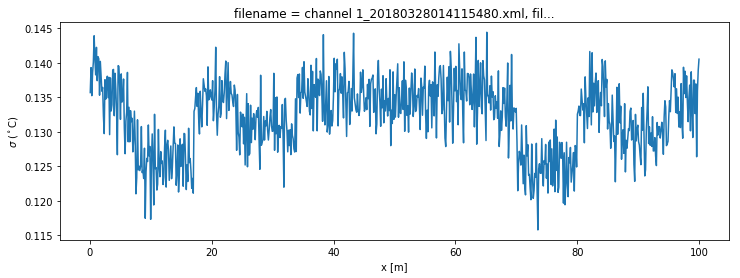

In [10]:
(ds1.TMPW_MC_var**0.5).plot(figsize=(12, 4));
plt.ylabel('$\sigma$ ($^\circ$C)');

In [11]:
ds.data_vars

Data variables:
    ST                     (x, time) float64 4.049e+03 4.044e+03 ... 3.501e+03
    AST                    (x, time) float64 3.293e+03 3.296e+03 ... 2.803e+03
    REV-ST                 (x, time) float64 4.061e+03 4.037e+03 ... 4.584e+03
    REV-AST                (x, time) float64 3.35e+03 3.333e+03 ... 3.707e+03
    TMP                    (x, time) float64 16.69 16.87 16.51 ... 13.6 13.69
    acquisitionTime        (time) float32 2.098 2.075 2.076 2.133 2.085 2.062
    referenceTemperature   (time) float32 21.0536 21.054 ... 21.0531 21.057
    probe1Temperature      (time) float32 4.36149 4.36025 ... 4.36021 4.36118
    probe2Temperature      (time) float32 18.5792 18.5785 ... 18.5805 18.5723
    referenceProbeVoltage  (time) float32 0.121704 0.121704 ... 0.121705
    probe1Voltage          (time) float32 0.114 0.114 0.114 0.114 0.114 0.114
    probe2Voltage          (time) float32 0.121 0.121 0.121 0.121 0.121 0.121
    userAcquisitionTimeFW  (time) float32 2.0 2.0 2.